[http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/?tdsourcetag=s_pctim_aiomsg](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/?tdsourcetag=s_pctim_aiomsg)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

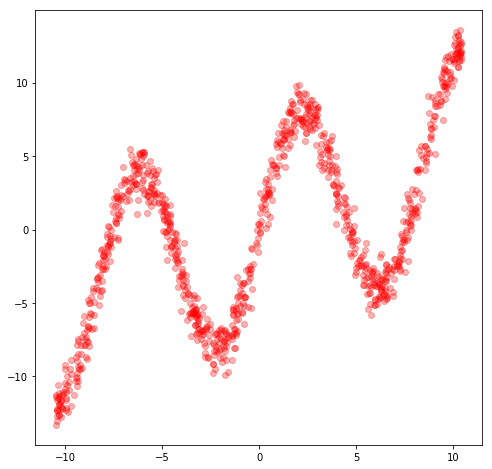

In [3]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [4]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [5]:
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

In [6]:
lossfunc = tf.nn.l2_loss(y_out-y);

In [7]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
NEPOCH = 1000
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})

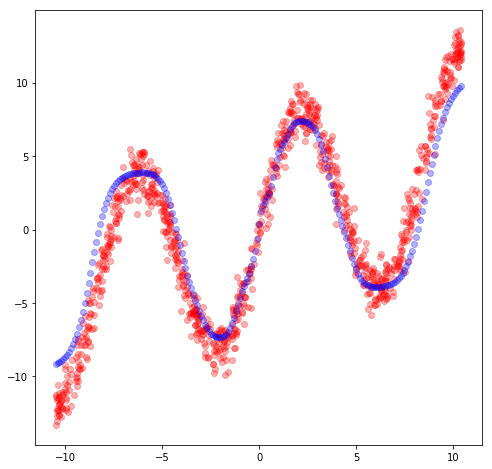

In [10]:

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

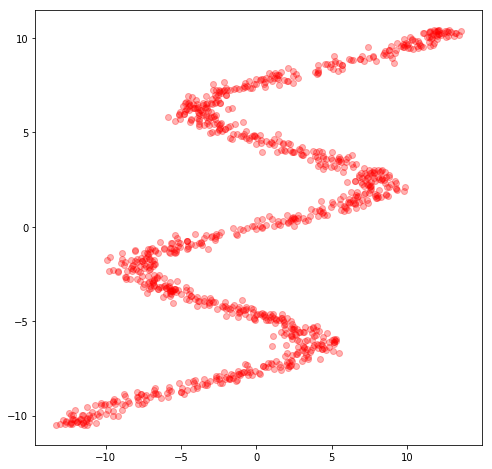

In [11]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

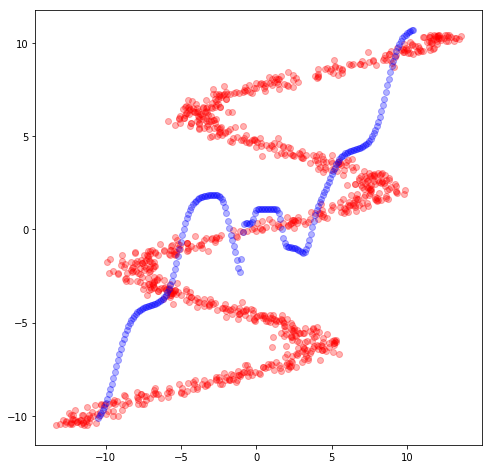

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

In [13]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

    out_pi, out_sigma, out_mu = tf.split(output, 3, 1)

    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)

    out_pi = tf.exp(out_pi)

    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)

    out_sigma = tf.exp(out_sigma)

    return out_pi, out_sigma, out_mu

out_pi, out_sigma, out_mu = get_mixture_coef(output)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


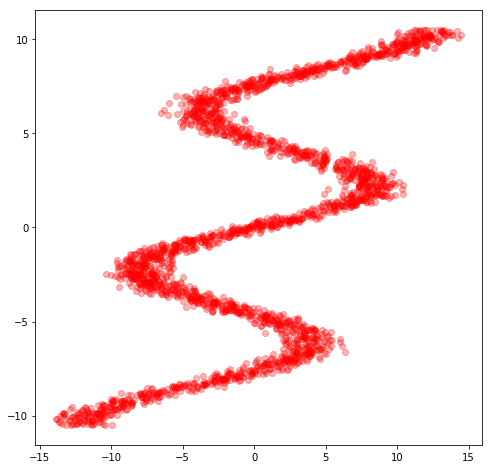

In [14]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [15]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})

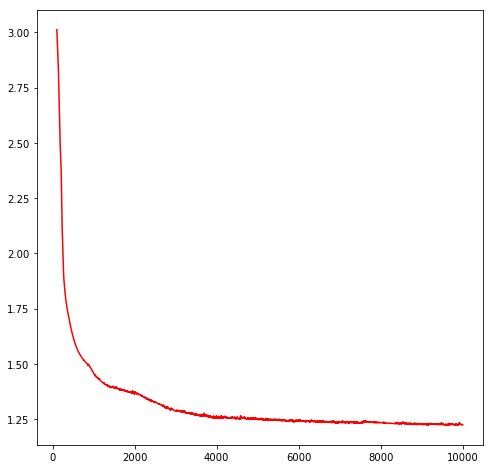

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [18]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print ('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

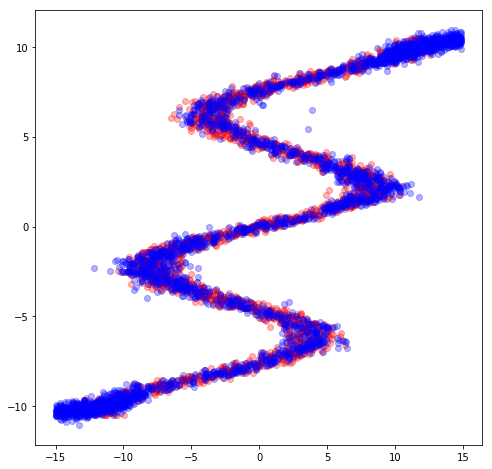

In [19]:

out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

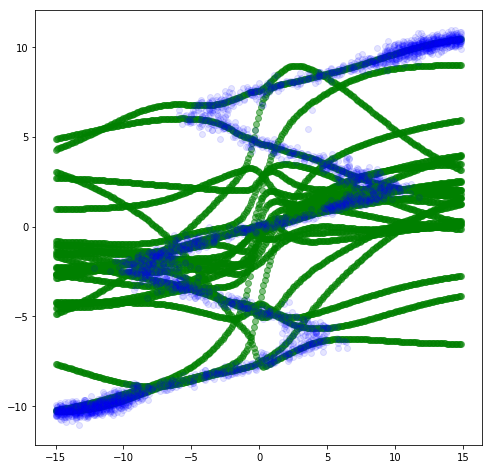

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(x_test,out_mu_test,'go',alpha=0.5)
plt.plot(x_test,y_test,'bo',alpha=0.1)
plt.show()

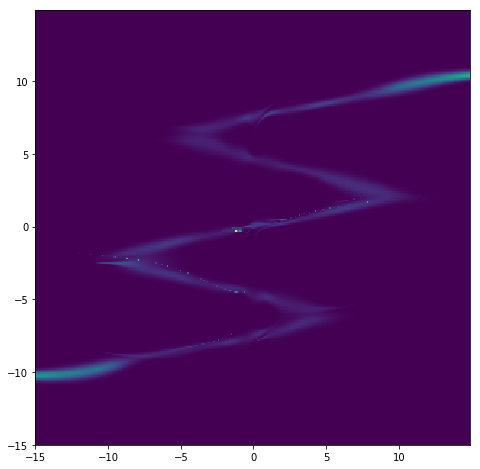

In [21]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

def custom_gaussian(x, mu, std):
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = KMIX

    z = np.zeros((N, M)) # initially random [0, 1]

    mu = 0
    std = 0
    pi = 0

  # transforms result into random ensembles
    for k in range(0, K):
        for i in range(0, M):
            pi = out_pi[i, k]
            mu = out_mu[i, k]
            std = out_sigma[i, k]
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)
    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent)
    plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)